# Joseph Souber, Scientific Computing Report.

# Technical Demonstrations:

Please import these tools before running demonstrations.

In [10]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import numdifftools as nd
from scipy.optimize import fsolve
import random
import scipy
import math
import matplotlib
from scipy.sparse import diags, identity
from scipy.sparse.linalg import spsolve


# ODE Solver

The following code demonstrates how to solve first and second order ODE's using my software.

# First Order

To solve a first order ODE of the form $\frac{dx}{dt} = x$ it must first be written as a python funtion as follows:


In [11]:
def f(x, t):
    return x

Now the ODE can be solved using custom ODE solver. Within this solver it is possible to specify a particular solving method from Euler's method, Runge-Kutta 4th order and Heun 3rd order. The initial condition x0 at time t=0 must also be specified, alongside the start and end times and the step-size the solver is to take. Finally, it should be specified whether it is a first or second order ODE: 'True' if it is a system of equations, otherwise 'False'. In this example, Heun's method will be used.

In [12]:
from ODE import solve_ode

# Set up the initial conditions
x0 = 1.0
t_eval = np.linspace(0, 5, 101) # time points to evaluate the solution
max_step = 0.01 # maximum step size for the solver
method = 'heun' # numerical method for the solver
system = False # the ODE is not a system

# Solve the ODE using the solve_ode function
X = solve_ode(f, x0, t_eval, max_step, method, system)

To verify the numerical solution it can now be plotted against the true solution, which is known to be:

$x(t)=e^t$,

using my homemade plotter

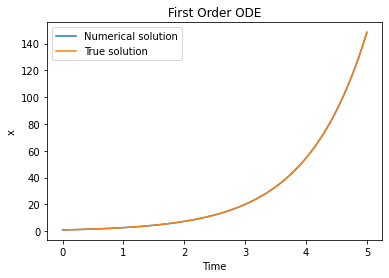

In [13]:
from plots import plot_ode

def true_sol(t):
    return np.exp(t)

plot_ode(X,true_sol,t_eval)

# Higher Order ODEs

To solve higher order ODEs it is necessary to first convert the ODE into a system of first order ODEs. For example, the second order ODE $\ddot{x} = -x$, can be written as $\dot{x} = y$ and $\dot{y} = -x$. This is coded as a function to be passed to solve_ode as follows:

In [14]:
def f_ddot(X,t):
    x, y = X
    dxdt = y
    dydt = -x
    return np.array([dxdt, dydt])

This can now be passed to solve_ode. I will demonstrate the solution using Runge-Kutta 4th Order solver this time. It should be noted that the parameter distinguishing between system of ODEs is now set to 'True'.


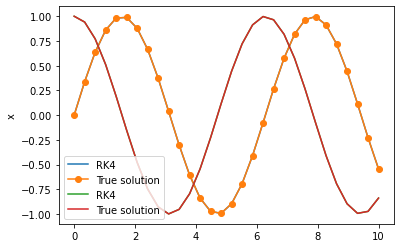

In [15]:
from plots import plot_system_ode

# Set up the initial conditions
x0 = [0, 1] # initial values of x and y
t_eval = np.linspace(0, 10, 30) # time points to evaluate the solution
max_step = 0.01 # maximum step size for the solver
method = 'RK4' # numerical method for the solver
system = True # the ODE is a system

# Solve the ODE using the solve_ode function
X = solve_ode(f_ddot, x0, t_eval, max_step, method, system)

def ddot_true_sol(t):
    x = np.sin(t)
    y = np.cos(t) 
    u = np.array([x, y])
    return u

plot_system_ode(X,t_eval,ddot_true_sol)

As the numerical solutions and analytical solutions so closely match, it appears as if only two line are plotted, when in fact 4 are present.

# Error Evaluation and Code Testing

To Evaluate the performance of the three different Numerical solvers I have implemented a function that calculates the error between the numerical and analytical solutions within a specific tolerance at varying timesteps. 


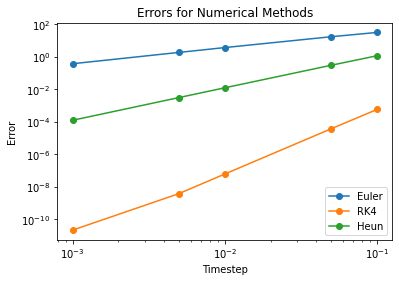

In [16]:
from plots import plot_error

def f(x, t):
    return x

# Define the true solution exp(t)
def true_sol(t):
    return np.exp(t)
x0 = 1  # initial condition
t0 = 0  # initial time
t1 = 5  # final time
dt_list = [0.1, 0.05, 0.01, 0.005, 0.001]  # list of timestep sizes to compare
args = ()  # empty tuple since there are no additional arguments for f
plot_error(f, true_sol, x0, t0, t1, dt_list, *args)

The above plot clearly demonstrates the superiority of the Runge-Kutta 4th order method, with the smallest error over a range of timesteps. 

# Numerical shooting


Before numerical_shooting is implemented, the predator-prey equations (Lokta-Voltera) are investigated. These take the form of: $\newline$
$\frac{dx}{dt} = x(1-x)-\frac{axy}{d+x}$

and

$\frac{dy}{dt}=by(1-\frac{y}{x})$

where a = 1, d = 0.1 and b = [0.1,0.5]

Below, the equations are plotted using a homemade plotting function. The first plot shows the differential equations for b<0.26. The second for b>0.26.

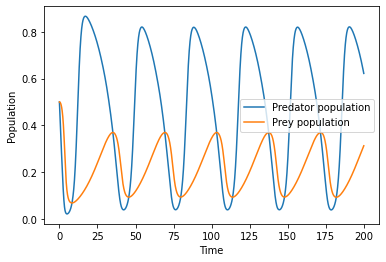

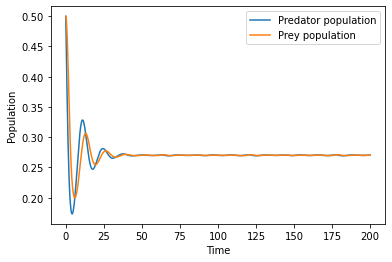

In [17]:
from shooting_plot import pred_prey_plot

def pred_prey_eq(X, pars):
  
    x = X[0]
    y = X[1]
    a, b, d = pars[0], pars[1], pars[2]
    dxdt = x * (1 - x) - (a * x * y) / (d + x)
    dydt = b * y * (1 - (y / x))
    return np.array([dxdt, dydt])


a = 1
d = 0.1
bs = [0.1,0.5]

pred_prey_plot(a,d,bs,pred_prey_eq)

As shown above for b<0.26 the solutions oscillate periodically and as b increases, x and y reach a stable equilibrium. 

I now implement a numerical shooting algorithm, which locates the initial conditions of the periodic orbit of the Predator-prey equations. For my shooting algorithm to work it is necessary to first define a phase condition. Ths phase condition has been determined to be $\frac{dx}{dt}(0)= 0$ from the course notes. I have passed in the same arguments for the predator-prey equation as before, with b fixed as 0.1.

[ 0.81978612  0.16575823 34.06873819]


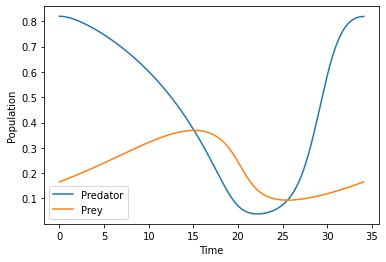

In [18]:
from shooting_plot import plot_solutions

def predator_prey(t, y, args = [1, 0.1, 0.1]):
    x = y[0]
    y = y[1]

    a = args[0]
    d = args[1]
    b = args[2]
     
    dxdt = x * (1 - x) - (a * x * y) / (d + x)
    dydt = b * y * (1 - (y / x))
    return np.array([dxdt, dydt])
    
def pc_predator_prey(u0, args = [1, 0.1, 0.1]):
    return predator_prey(0, u0, args = [1, 0.1, 0.1])[0]

# Define the initial guess for the shooting method
u0 = [0.8, 0.3,30]
plot_solutions(predator_prey,pc_predator_prey,u0,args=(), max_step=0.01)

The above code plots the isolated orbit found by the shooting algorithm.

I now test my shooting discretisation with the normal hopf bifurcation, to see if the initial conditions and period returned by my shooting function, provide accurate guesses to solve the system of differential equations. 

The normal hopf bifurcation is defined as: 

$\frac{du_1}{dt}=\beta u_1 - u_2 + \sigma u_1({u_1}^2+{u_2}^2) \newline$
$\frac{du_2}{dt}= u_1 - \beta u_2 + \sigma u_2({u_1}^2+{u_2}^2)$

with $\sigma = -1$ (supercritical Hopf) having explicit solutions:

$u_1(t)=\sqrt{\beta}cos(t+\theta)\newline$
$u_2(t)=\sqrt{\beta}sin(t+\theta)$

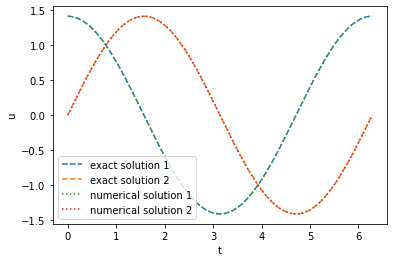

In [19]:
from shooting_plot import shooting_generalised, plot_hopf_shooting

def normal_hopf(u0, t, beta):

    #beta = pars[0]
    u1, u2 = u0[0], u0[1]

    du1dt = beta * u1 - u2 - (u1) * (u1 ** 2 + u2 ** 2)
    du2dt = u1 + beta * u2 - (u2) * (u1 ** 2 + u2 ** 2)
    return np.array([du1dt, du2dt])


# phase condition for the normal Hopf bifurcation (u1 gradient = 0)
def pc_normal_hopf(u0, pars):
    return normal_hopf(u0, 0, pars)[0]

u0_guess_hopfnormal = np.array([1.5, 0.1, 6.1]) # initial guess for the shooting method
pc = pc_normal_hopf # phase condition
beta = 2 # parameter value
initial_pars0 = (pc, beta) # tuple of arguments for the shooting method

# Solve the ODE system using the specified method and solver.
sol = np.array(fsolve(shooting_generalised(normal_hopf),u0_guess_hopfnormal, args=initial_pars0))
plot_hopf_shooting(sol, pc_normal_hopf, 2, normal_hopf)

The above plot from my homemade plotter, shows that the numerical and exact solutions are very similar.

# Numerical Continuation



In order to move beyond boundary-value problems and investigate parameter dependance, two methods of numerical continuation have been developed: Natural Parameter Continuation (NPC) and Pseudo-Arc-length continuation. 

They both have the ability to solve differential equations, by allowing the user to specify whether a discretisation is necessary. If it is, a generalised version of my numerical shooting function is implemented to find the first solution. This is then iterated through a set of parameters. 

Initially, the pseudo-arclength continuation is demonstrated by using the equation: $\delta\bar{u}\cdot(\bar{u}-\tilde{\bar{u}})+\delta p\cdot(p-\tilde{p})=0$ on a standard cubic equation of the form: $x^3 - x +c$ and the bifurcation diagram is plotted. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


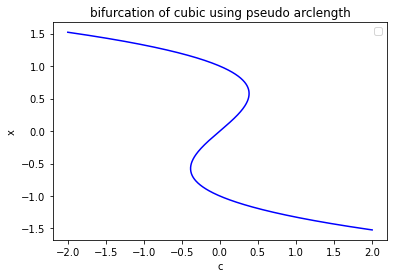

In [20]:
from plots import bifurc_plot
from numerical_continuation import pseudo_arclength, npc

def cubic_eq(x, c):
    
    return x**3 -x +c

# Define the discretisation function
def disc(init_conds, ode_func, A):
    return ode_func(init_conds, A)

pseudo_par_list, pseudo_sol_list = pseudo_arclength(cubic_eq, 1, (-2, 2), 0.01, discretisation=disc)


# Plot results - x against c
bifurc_plot(pseudo_par_list, pseudo_sol_list,'bifurcation of cubic using pseudo arclength')


This demonstrates the superirority of the Pseudo-arclength method, as it elegantly handles the folds in the cubic equation. 

As aforementioned, it is necessary to discretise differential equations in order to gain an initial solution guess for continuation to work. This is demonstrated below; once again using the phase condition defined in shooting.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


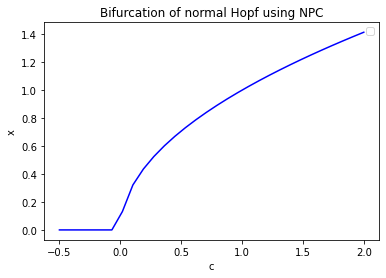

In [21]:
from shooting_plot import shooting_generalised

# Define the hopf system
def normal_hopf(u0, t, pars):

    beta = pars[0]
    u1, u2 = u0[0], u0[1]

    du1dt = beta * u1 - u2 - (u1) * (u1 ** 2 + u2 ** 2)
    du2dt = u1 + beta * u2 - (u2) * (u1 ** 2 + u2 ** 2)
    return np.array([du1dt, du2dt])


# phase condition for the normal Hopf bifurcation (u1 gradient = 0)
def pc_normal_hopf(u0, pars):
    return normal_hopf(u0, 0, pars)[0]

guess_hopfnormal = np.array([1.5, 0.1, 6.1]) # initial guess for the shooting method

natpam_par_list, natpam_sol_list = npc(normal_hopf, guess_hopfnormal, [2], -0.5,shooting_generalised, fsolve,pc = pc_normal_hopf)

# norm of the solution because it is a 2D system
norm_natpam_sol_list = scipy.linalg.norm(natpam_sol_list[:, :-1], axis=1, keepdims=True)

bifurc_plot(natpam_par_list, norm_natpam_sol_list,'Bifurcation of normal Hopf using NPC')


# PDE 

The overall aim of the PDE solvers I have built, is to use them to solve nonlinear diffusion equations of the form:

$\frac{du}{dt}= D\frac{{\delta^2}u}{{\delta}x^2}+q(x,t,u;\mu)$

Below I have various demonstrations, increasing in complexity. 


I show how to use my finite difference solver to solve:$\frac{\delta u}{\delta t} = D\frac{{\delta^2}u}{\delta{x^2}}$ numerically using the Explicit Euler method, the Implicit Euler method and the Crank Nicholson method. With the Dirichlet boundary conditions $u(a,t)=u(b,t)=0$, Neumann boundary conditions $\frac{\delta u(0,t)}{\delta x}=\frac{\delta u(L,t)}{\delta x} = 0 $ and the initial condition $u(x,0)=sin(\frac{\pi(x-a)}{b-a})$, where a =0.

In order for my finite difference solver to work, the user must first define some functions, these are outlined below.

/var/folders/vx/p6h8zj0n0wxd9qrn2pk09l9c0000gn/T/ipykernel_42168/2970091874.py:25: RuntimeWarning: invalid value encountered in true_divide
  return x / (x * 10)


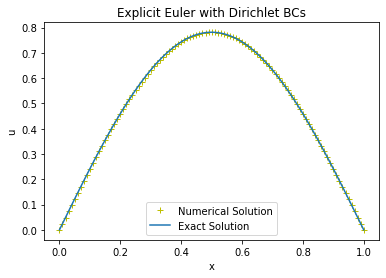

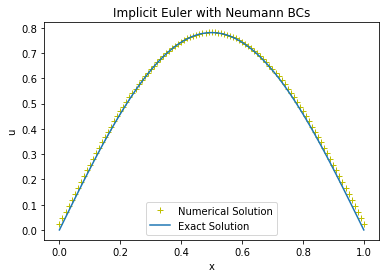

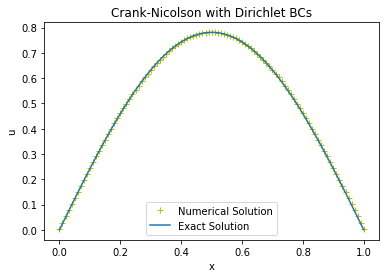

In [22]:
from PDE import *
from plots import plot_comparison


L = 1 # length of the domain
T = 0.5 # total time
mx = 100 # number of grid points in space
mt = 1000 # number of grid points in time

def u_exact(x, t,D,L):  
    y = np.exp(-D*(np.pi**2/L**2)*t)*np.sin(np.pi*x/L)
    return y

# Dirichlet boundary conditions, 0 on both ends.
def dirichlet_0(x, t):
    return 0

# Initial condition, sin(pi*x/L).
def Initial_Condition(x, L):
    y = (np.sin(np.pi*x/L))
    return y

# Diffusion coefficient,needs to be a function of x, to be compatible with the finite difference method.
def D(x):
    return x / (x * 10)

# Source term, needs to be a function of x and t, to be compatible with the finite difference method. 0 for this demonstration.
def source_term(x,t):
    return 0


#explicit euler and dirichlet
u, t = finite_difference(L, T, mx, mt, 'dirichlet', dirichlet_0, Initial_Condition, discretisation='explicit',source_term = source_term, D = D, linearity='linear')
#implicit euler and neumann
u1, t1 = finite_difference(L, T, mx, mt, 'neumann', dirichlet_0, Initial_Condition, discretisation='implicit',source_term = source_term, D = D, linearity='linear')
#Crank-Nicolson and dirichlet
u2, t2 = finite_difference(L, T, mx, mt, 'dirichlet', dirichlet_0, Initial_Condition, discretisation='cn',source_term = source_term, D = D, linearity='linear')

# Plot the solution at T/2.
plot_comparison(u, t, L, 0.1,u_exact,'Explicit Euler with Dirichlet BCs')
plot_comparison(u1, t1, L, 0.1,u_exact,'Implicit Euler with Neumann BCs')
plot_comparison(u2, t2, L, 0.1,u_exact,'Crank-Nicolson with Dirichlet BCs')

I now wish to demonstrate how my solver can handle non-homogenous boundary conditions. I am using the example from Week 20: $\frac{du}{dt}= D\frac{{\delta^2}u}{{\delta}x^2}+q(x,t,u;\mu)$, where in the supplmentary notes a solution is provided for the case where $u(a,t)=\alpha,u(b,t)=\beta$ where $\alpha = 1,\beta = 0, q(x,t,u;\mu) = 0$ and $u(x,0)=f(x)=0$.

The exact solution provided by the notes: $u(x,t)= {1 - \frac{x-a}{b-a} - \frac{2}{\pi}}{\sum_{n=1}^{\infty}\frac{1}{n}{exp(-\frac{{n^2}{\pi^2}{Dt}}{(b-a)^2})}sin(\frac{n\pi(x-a)}{b-a})}$

/var/folders/vx/p6h8zj0n0wxd9qrn2pk09l9c0000gn/T/ipykernel_42168/1114680268.py:21: RuntimeWarning: invalid value encountered in true_divide
  return x / (x * 10)


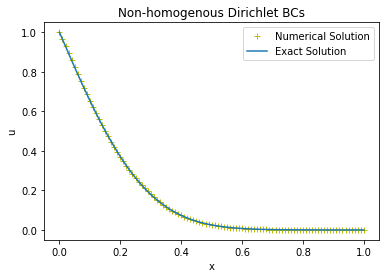

In [23]:
L = 1
T = 0.5
mx = 100
mt = 1000


def Initial_Condition(x, L):

    return 0

# Dirichlet boundary conditions, 1 on the left end, 0 on the right end.
def dirichlet_nonhomogenous(x, t):

    if x==0:
        return 1
    else:
        return 0


def D(x):
    return x / (x * 10)

def source_term(x,t):

    return 0

def u_exact_dnonhomo(x,t,D,L):

    sum = 0
    for n in range(100):
        n+=1
        sum += (1/n)*(np.exp(-1*D*(n**2)*(np.pi**2)*t)) * np.sin(n*np.pi*x)

    y = 1-x-(2/np.pi)*sum
    return y


u, t = finite_difference(L, T, mx, mt, 'dirichlet', dirichlet_nonhomogenous, Initial_Condition, discretisation='explicit', source_term = source_term,D = D,linearity='linear')


plot_comparison(u, t, L, 0.1,u_exact_dnonhomo,'Non-homogenous Dirichlet BCs')

Now I solve the dynamic Bratu problem: $\frac{du}{dt}= D\frac{{\delta^2}u}{{\delta}x^2}+e^{\mu u}$, with $u(0,t)=u(1,t)=0$ and $u(x,0)=0$ and D=1. I have found an arbitary exact solutions using separation of variables, to compare my numerical solution against.


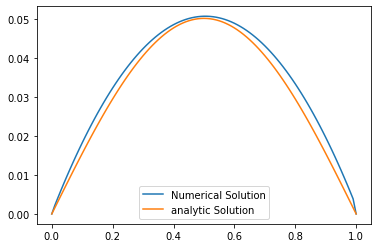

In [24]:
from plots import plot_bratu

# homogenous boundary conditions
def dirichlet_0(x,t):

    return 0

def Initial_Conds(x, t):

    return 0

#bratu source term
def Bratu(u, x, t):
    mu = np.linspace(0,0.1,101)
    y = np.exp(mu*u)
    return y

import numpy as np

def bratu_exact(x, t, D, L, mu=0.1):
    """
    Computes the exact solution to the Bratu equation with the given
    boundary and initial conditions.
    
    Parameters:
        x (numpy.ndarray): 1D array of spatial grid points
        t (float): time
        D (float): diffusion coefficient
        L (float): length of the spatial domain
        mu (float): nonlinear coefficient
    
    Returns:
        u (numpy.ndarray): 1D array of solution values at the grid points x
    """
    u = np.zeros_like(x)  # initialize solution array
    
    for n in range(1, 100):  # sum over all positive integers up to 99
        lambda_n = -D * n**2 * np.pi**2 - np.exp(mu)
        B_n = 1.35 # initial condition u(x,0) = 0
        
        u += B_n * np.sin(n * np.pi * x) * np.exp(lambda_n * t)
    
    return u

def exact(D,x):

    y = 0.5*(-1/2*D)*x*(x-1)
    return y

u,t = finite_difference(L, T, mx, mt, 'dirichlet', dirichlet_0, Initial_Conds, discretisation='implicit', source_term = Bratu, D=1, linearity='nonlinear')


plot_bratu(0.3,u,t,L,mx,bratu_exact)

I believe the numerical solution to be correct, as I have derived the analytical solution myself and they both exhibit the same shape.

I now use my code to attempt to solve the Allen-Cahn equation on the domain $0\leq x \leq 1$, with $\epsilon = 0.01$ until t=50.

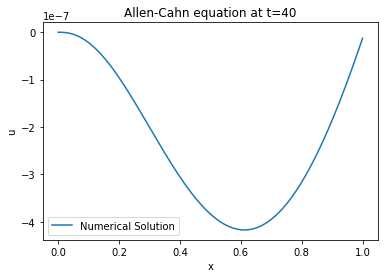

In [25]:
#Allen-Cahn
from plots import plot_allen_cahn
random.seed(123)

L = 1
T = 50
mx = 150
mt = 1000

def dirichlet_0(x,t):
    '''
    Function containing the homogeneous boundary conditions.
    '''
    return 0

def Initial_Conds(x, t):

    return np.array([random.uniform(-0.001, 0.001)]) 


def nonlinear_source(u, x, t):
    
    y = u - u**3
    return y

u,t = finite_difference(L, T, mx, mt, 'neumann', dirichlet_0, Initial_Conds, discretisation='implicit', source_term = nonlinear_source, D=0.0001, linearity='nonlinear')

plot_allen_cahn(u,t,40,L)

# Key Design Decisions: 

# ODE: 
The main function is ‘solve_to’, which iteratively uses a specified method from one of Euler, Runge-Kutte 4th Order or Heun; until it reaches or exceeds t1. A deliberate choice was made that if the next time of the iteration is going to exceed t1, ‘max_step’ is updated to be the minimum of its current value and the difference between t1 and t0. If t1 - t0 is smaller than the current ‘max_step’, it will be used as the step size for the last iteration, ensuring that the integration stops exactly at t1. If t1 - t0 is greater than or equal to the current ‘max_step’, the original ‘max_step’ will be used and the integration will continue as usual. 

I have also made both ‘solve_to’ and ‘solve_ode’ modular, allowing any new method to be added. This was demonstrated by the later addition of the Heun algorithm. Furthermore, the ODE solving class is designed to handle systems with arbitrary dimensions, with no user specification needed. 

A subtle but important factor within the ‘solve_ode’ function is setting up the solution matrix. I have included a simple if statement that will automatically initialise the X matrix to the correct size, depending on whether a system of ODEs is being inputted or not. This alleviates the need for the user to do this manually. 

# Shooting: 

Due to the time-sensitive nature of this project, I was unable to fuse my two shooting functions. The first shooting function, nested inside my ‘plot_solutions’ function, constructs the root-finding problem with Scipy’s built in ‘solve_ivp’. It also allows the user to specify solver of their choice, although it should be noted it is set up for fsolve. 'fsolve' from the scipy.optimize package was deemed to be the best choice, due to its simplicity in use and its efficiency. 

Although the first function is a completely valid way of implementing shooting, I went on to extend this function to produce a generalised version of shooting, which could discretise any ODE system. This ‘shooting_generalised’ made use of homemade ‘solve_ode’ function, which is set as a default to use the RK4 method, as it is the highest order method; this is an example of code layering. Had I more time, I would have liked to combine these functions into one simple one, however one does not detract from the other. I also made a conscious decision for phase condition to always be parsed through, as this might become a complex argument in more complicated systems. 

# Code Testing: 

I have implemented a range of different code testing throughout this project. In the file ‘test_solutions’, there are input and output tests for each major part of my software. The input tests show how my code can gracefully handle incorrect inputs, whilst the output tests demonstrate numerical solutions from my software are of the correct form and within a certain tolerance to any analytical solutions I was able to obtain, using __np.allclose()__. Furthermore, I have used the __assert__ function to make sure variables are inputted correctly and return informative messages when they are incorrect. All code tests can be seen by running the ‘test_solutions’ file. 

# Continuation: 

As continuation only involved two functions, I felt no need to modularise this in a third function. Therefore, the user can call either the ‘npc’ function for natural parameter continuation, or the ‘pseudo_arclength’ function. A key design choice was the necessity to include my ‘shooting_generalised’ function as a form of discretisation for ODE systems like the normal hopf. The ‘npc’ function performs natural parameter continuation on a function by iterating over a range of 30 parameter values providing a balance between computational efficiency and accuracy, solving the system at each step using the provided discretisation method, solver, and initial conditions, and then updating the initial conditions for the next step. The function returns an array of parameter values and an array of corresponding solution points, which can be used to analyse the behaviour of the system as the parameter varies. The design choices, such as defaulting to the 'shooting_generalised' method and using fsolve as the solver, were made to balance computational efficiency and accuracy, while providing flexibility in customizing the function for specific use cases. 

As this project was meant to push our software engineering skills, I experimented with some new commands. For example, __setitem__ was used. Furthermore, I wanted to test computational efficiency by using short-circuit evaluation instead of if-else statements. This is demonstrated in the line: ‘__param_init = (pc or ‘’) and ((pc or ‘’) != ‘none’) and (pc, pars) or pars__ ‘. 

Depending on the parameter value chosen to start on, the algorithm may begin iterating on the wrong side of the fold. Therefore, ‘vary_min’ was introduced from the offset, so that the user can decide where the operation begins. On the downside of this, I was not able to implement any particular way of checking whether the ‘vary_min’ value specified would start in the wrong place. This places the onus on the user to provide a good starting value. 

For Pseudo-Arclength Continuation the deliberate design choices in this implementation include the use of a dictionary to store various functions, the use of the fsolve function to solve the nonlinear system of equations, and the implementation of a stopping condition that considers the direction of the parameter variation. I have chosen to use a dictionary as I believe it is a neater way to implement multiple functions that need to be called at different times. I have also experimented with the use of anonymous (lambda) functions, to make my coding more efficient. Once again, fsolve is used for the aforementioned reasons. 

# PDEs: 

The first thing to notice is that I separated the key operations of my PDE solvers into separate functions. This was done to avoid repetition and make the code easier to understand. For example, separate functions that apply boundary conditions and make the tridiagonal matrices were defined. These functions were then called in each finite difference method (Explicit, Implicit, CN), as opposed to being hard coded into each function. This also made adding in different boundary conditions such as Neumann easier, as it was only necessary to adjust the matrix building functions. 

I also opted to structure my ‘finite_differences’ function like my ‘solve_ode’ function, where each solver can be specified within the so-called finite differences function. This function then takes one of the solving methods, which only does a single step and loops it through a specified time. This makes it more straightforward for the user. I have also added a Value error message for the Explicit Euler method and named it ‘Euler_flag’. This is representative of the 'C' which should be no greater than 0.5, for the method to work. 

One choice to note is my variation in the diffusion constant D. When setting up my functions I was always using D as a function, this was to account for PDE problems with a variable diffusion constant. This mainly affects the setting up of the tridiagonal matrix, as with a constant diffusion constant the diagonals can be comprised of specific integers with the end values changing depending on boundary type. However, I realised that, if I wanted to implement a D that varies, this would mean implementing coefficients for the diagonals that depend on time and space. This is the method I opted for. I later ran into too many problems when trying to implement this variable diffusion constant code for nonlinear source terms, hence the distinction between linear and nonlinear in ‘tridiagonal_mat’, turning D into a float if nonlinear is specified. 

Within the Implicit and Crank Nicholson methods I have implemented a Newton’s method for root-finding, which sets up a linear system of equations and then uses ‘spsolve‘ to solve, allowing PDE systems with nonlinear source terms to be solved. The difference in implementation shows my design process, as I initially attempted to construct the non-linear problem without consultation of course notes. This is demonstrated in the implicit implementation. After consulting the notes, I attempted to implement Newton's method instead. I left both in, as they perform differently and I didn’t have time to perfect Newton's method. I have provided a simple block diagram below, that I used to form the basis of my Crank-Nicholson function. 

Each solver was implemented using sparse matrices. Sparse matrices offer significant advantages in terms of computational efficiency and storage requirements in comparison to their dense counterparts. The primary benefit of sparse matrices is that they only store non-zero elements, which drastically reduces the memory needed for representing large-scale data sets with a high percentage of zero values such as the tridiagonal matrices generated using the finite differences methods. Additionally, when using specialized algorithms like spsolve, which is designed to efficiently solve linear systems involving sparse matrices, the computational time is substantially reduced. 

I have animated three PDE systems in the 'animate' file, demonstrating how the solutions develop over time. The file is set up to simply be run.

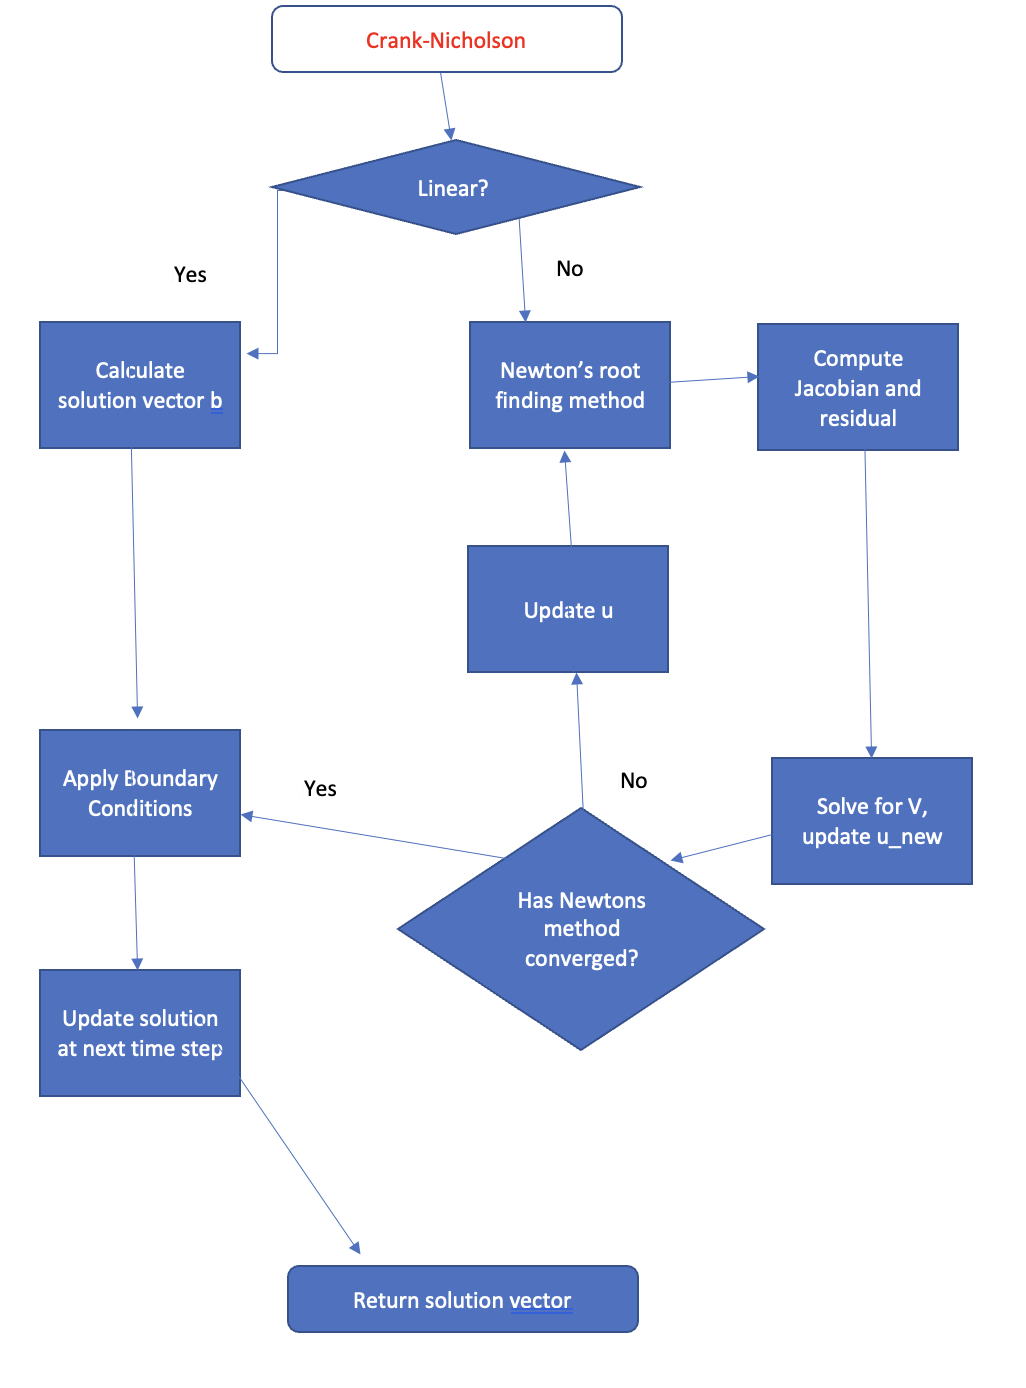

In [26]:
from IPython.display import Image
Image("flowchart.png",height = 500,width = 500)

# Reflective learning log
 
Prior to this project I had completed a few assignments involving Python, however my understanding of the language was somewhat crude. This coursework has given me invaluable skills and really developed my ability to programme.

Initially, it was challenging to carry over mathematical knowledge for PDEs, ODEs and the like, into the world of programming. I had previously encountered some of these mathematical concepts before, but never had I had to code them up. Consequently, I gained a deeper understanding of the inner workings of these methods; I wasn’t simply using them to solve questions, but really having to understand how they work.

Immediately from the outset, using functions became a necessary skill to learn. I had always coded in a top-down manner, normally line by line to achieve an objective. This project has taught me that a bottom-up approach is clearly preferrable. By identifying my objective, I could modularise my code into separate functions, each working together to achieve this objective. This was not something I had really done before, but now will be a permanent methodology for me. Not only does it separate tasks to prevent being overwhelmed, it makes the code more readable and shows a progression of logic.

Regarding the shorter-term implications of what I have learnt, although I did not choose to implement key-word-arguments, this was a new concept to me, and I am now aware of their syntax when passing into a function by defining it with ‘=’ and all following arguments must also be keyword. I had also never integrated my own written code in different files and understood the use of  'if __name__ = __main__', but now after having to integrate functions from different files< I can see how useful it is, in ensuring correct information is displayed when the function is called. I had imported libraries and tools before, but never learnt to modularise code such that it could be imported across files. I will now attempt to write all future code like this. This modularisation of code means extensive planning before implementation. Often throughout this project, I had to start again from the ground up because I had not planned functionality well enough, and it was easier to re-write than to get functions to behave together. 

Something I found very helpful throughout the project was a better understanding of git. Through using the git extension on VSCode, I was able to make regular commits. This meant that when errors arose, I was able to sift through my history and restore code to a working version. I have now learnt that small and regular commits are far superior to a large commit when code is fully complete. This is for the aforementioned reasons, so I can track my changes effectively. This improved use of git is something I will use in the future and implement in multiple future projects.

As my code progresses you can see the addition of dictionaries. This was something new to me and I found it very useful to implement dictionaries within functions that contained many nested functions. Dictionaries make the code more readable and concise, whilst also helping with efficiency as I could simply call what function was needed from a dictionary, instead of running through each function sequentially. This was used in conjunction with lambda functions, especially in my pseudo-arclength code. I found using lambda functions great for keeping code concise.

Although commenting code is something every beginner programmer is told to do, I had never come across docstrings before. I found these immensely useful for increasing the readability of my code, so it can be easily understood by other people. It also meant I could return to code I had written a while prior and quickly remember what certain parts were doing. I now understand that using a Jupyter notebook alongside the code is efficient and effective; it is an easy and informative way to display functionality.

A major part of this project was code testing. The concept of designing a series of tests to ensure a function works correctly was novel for me. I had never tested code before, it either ran or it didn’t. Although I implemented it slightly back to front, by testing code once it was already written, it is still an invaluable skill that I will carry forward with me. In future projects I will write the testing, prior to code, hence allowing the development of properly sound code. Output testing and functions such as timeit introduced a new aspect to my coding. I have only ever programmed to reach an objective before and never reached that objective and tested the performance to see if it could be improved. This is something this project taught me and something I have implemented. For example, I completely scrapped the way I was building my PDE integrator in favour of starting again and building functions using sparse matrices instead, to reduce computation time.

Alongside programming skills, I learnt a lot of helpful mathematical knowledge which will aid my future studies. Shooting, Continuation and Finite differences are all concepts that I had never encountered, despite having prior knowledge surrounding these topics. It was very exciting to see how the output from numerical continuation can be visualised as bifurcation diagrams, a concept familiar to me; hence showing me the link between the theory I had learnt and its practical implementation. Finite difference discretisation highlighted how many fields of mathematics can link. Taking a typical ODE problem and discretising it into a series of linear systems, which can then be solved using linear algebra techniques, was something I had never considered before.

Finally, I would say the most important thing this project has taught me is the need for significant planning. My time was managed poorly, as I did not adequately plan. I now understand that a roadmap should be drawn up before anything is started. Furthermore, code blocks must be meticulously planned before implementation. A poor example of this is my work on continuation. I started working on the functions at completely different times and did not adequately plan how they could be used together; meaning although they work, they are disjoint from one another. Towards the end of the project, I started using block diagrams to help organise my thoughts. Although they were simple, they still organised my functions effectively. Planning also ensures that you can determine how functions will collaborate, an essential part of this project. I did not begin by thinking about this and it meant many major changes were subsequently required in each section, when trying to layer code. Therefore, devoting time to planning before implementing is a major takeaway for me.
